### Energy Demand Forecasting

In [53]:
# importing packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# loading data

data = pd.read_csv('TimeSeries_TotalSolarGen_and_Load_IT_2016.csv')
data.head()

,utc_timestamp,IT_load_new,IT_solar_generation
0,2016-01-01T00:00:00Z,21665.0,1
1,2016-01-01T01:00:00Z,20260.0,0
2,2016-01-01T02:00:00Z,19056.0,0
3,2016-01-01T03:00:00Z,18407.0,0
4,2016-01-01T04:00:00Z,18425.0,0


#### Data Preprocessing

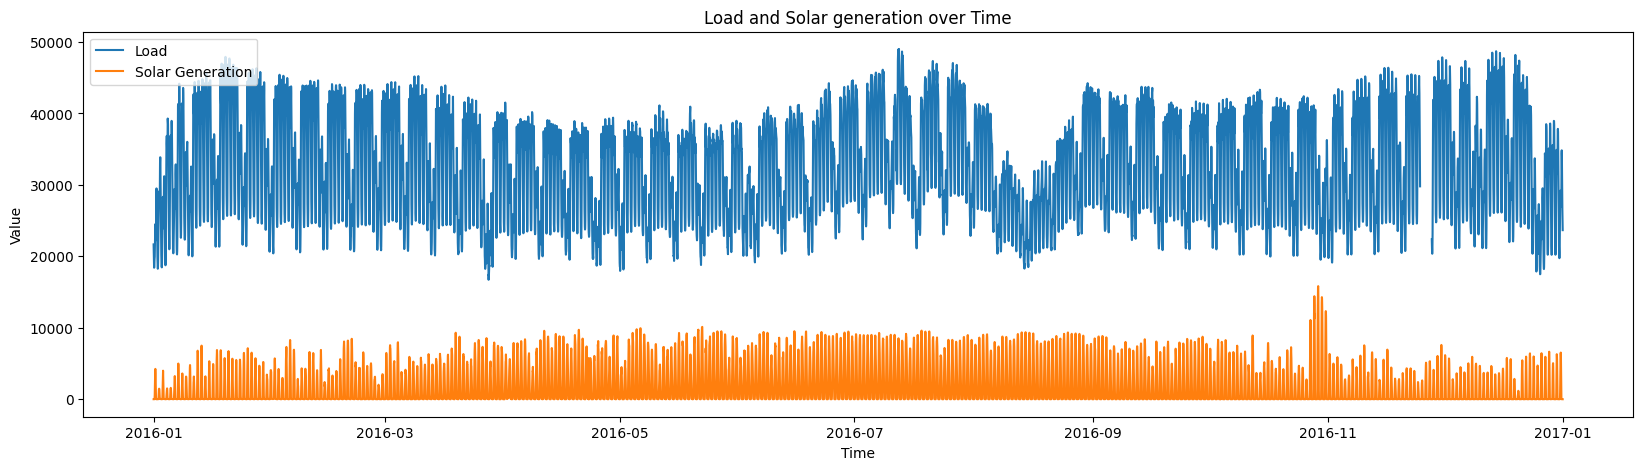

In [54]:
# Data Visualization

# converting timestamp to date time

data['utc_timestamp'] = pd.to_datetime(data['utc_timestamp'])

# plotting data

plt.figure(figsize = (20,5))

plt.plot(data['utc_timestamp'], data['IT_load_new'], label = 'Load')
plt.plot(data['utc_timestamp'], data['IT_solar_generation'], label = 'Solar Generation')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Load and Solar generation over Time')
plt.legend(loc = 'best')
plt.show()

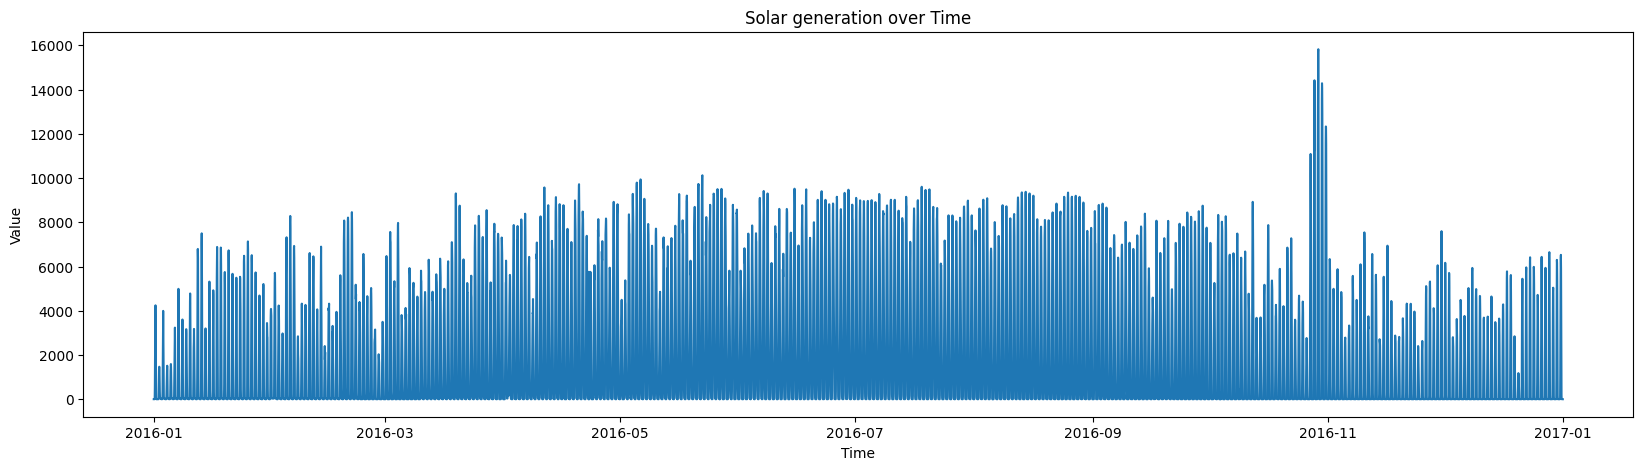

In [55]:
plt.figure(figsize = (20,5))

plt.plot(data['utc_timestamp'], data['IT_solar_generation'], label = 'Solar Generation')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Solar generation over Time')
plt.show()

In [56]:
# Handling missing Values

data.isnull().sum()

utc_timestamp           0
IT_load_new            72
IT_solar_generation     0
dtype: int64

In [57]:
data['IT_load_new'].fillna(method = 'ffill',inplace=True)
data.isnull().sum()

C:\Users\User\AppData\Local\Temp\ipykernel_1656\152178907.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['IT_load_new'].fillna(method = 'ffill',inplace=True)


utc_timestamp          0
IT_load_new            0
IT_solar_generation    0
dtype: int64

#### Stationarity Test

In [58]:
import statsmodels.tsa.stattools as sts

# function for Dickey Fuller test

def adf_test(timeseries):
    print('Results of Dickey Fuller Test:')
    dftest = sts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],index = ['Test Statistics', 'p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [59]:
# performing adf test

print("\nADF test for IT Load New:")
adf_test(data['IT_load_new'])

print("\nADF test for IT solar generation")
adf_test(data['IT_solar_generation'])



ADF test for IT Load New:
Results of Dickey Fuller Test:
Test Statistics               -1.197390e+01
p-value                        3.841445e-22
#Lags Used                     3.700000e+01
Number of Observations Used    8.746000e+03
Critical Value (1%)           -3.431098e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64

ADF test for IT solar generation
Results of Dickey Fuller Test:
Test Statistics               -5.741335e+00
p-value                        6.265438e-07
#Lags Used                     3.600000e+01
Number of Observations Used    8.747000e+03
Critical Value (1%)           -3.431098e+00
Critical Value (5%)           -2.861870e+00
Critical Value (10%)          -2.566946e+00
dtype: float64


p-values of both Sloar Generation and Load are lower than 0.05. Therefore, both series are stationary.

#### Build ARIMA model for 'IT Load new'

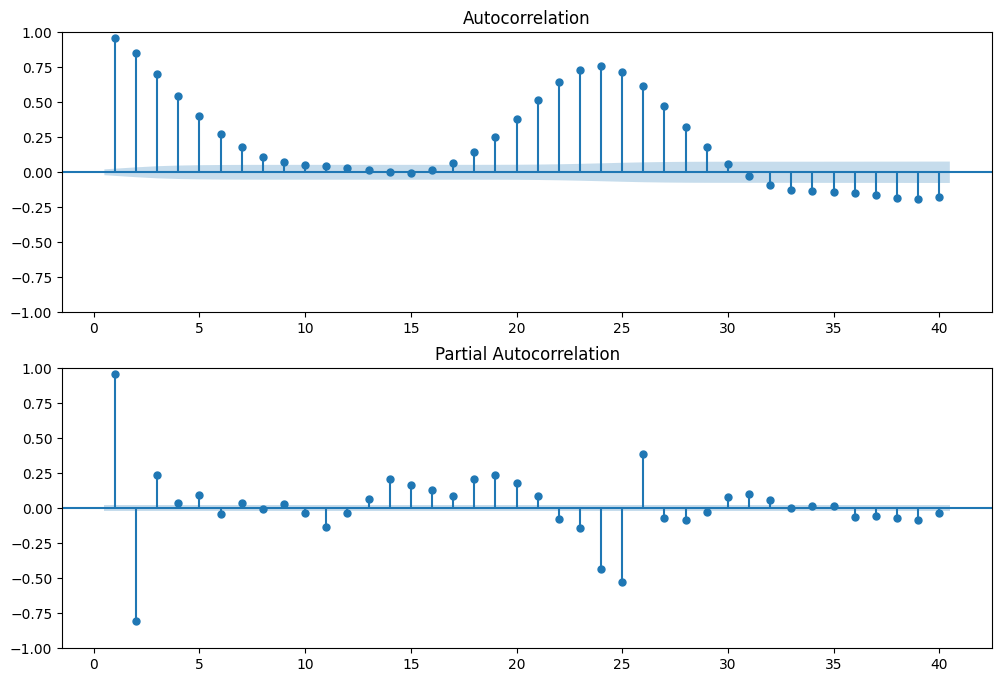

In [60]:
import statsmodels.graphics.tsaplots as sgt

# plotting ACF and PACF

fig, (ax1,ax2) = plt.subplots(2,1,figsize = (12,8))
sgt.plot_acf(data['IT_load_new'], lags =40, zero = False, ax = ax1)
sgt.plot_pacf(data['IT_load_new'], lags =40, zero = False, ax = ax2)
plt.show()



From the ACF plot, we see a gradual decrease, and from the PACF plot, there is a sharp drop after lag 2. So we can take p=2 and q=2 as our model parameters.

In [61]:
from statsmodels.tsa.arima.model  import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# splitting data into training and sets

train_size = int(len(data['IT_load_new']) * 0.8)
train, test = data['IT_load_new'][:train_size],data['IT_load_new'][train_size:]

# fit the arima model (2,0,2)

model =  ARIMA(train, order= (2,0,2))
model_fit = model.fit()

# make predictions on the test set

predictions_1 = model_fit.predict(start = len(train), end = len(train) + len(test) -1)

# Calculate RMSE

rmse = sqrt (mean_squared_error(test,predictions_1))
rmse

7714.95213485845

In [62]:
# fit the arima model (2,1,2)

model =  ARIMA(train, order= (2,1,2))
model_fit = model.fit()

# make predictions on the test set

predictions = model_fit.predict(start = len(train), end = len(train) + len(test) -1)

# Calculate RMSE

rmse = sqrt (mean_squared_error(test,predictions))
rmse

7993.849405145093

In [63]:
# fit the arima model (2,2,2)

model =  ARIMA(train, order= (2,2,2))
model_fit = model.fit()

# make predictions on the test set

predictions = model_fit.predict(start = len(train), end = len(train) + len(test) -1)

# Calculate RMSE

rmse = sqrt (mean_squared_error(test,predictions))
rmse

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9278.808888674403

The root mean squared error (RMSE) for the ARIMA model on 'IT_load_new' is approximately 7715. RMSE is a measure of the differences between the values predicted by a model and the values actually observed. It's a good measure of how accurately the model predicts the response, and it is the most important criterion for fit if the main purpose of the model is prediction.

However, the value of RMSE itself is not as informative as comparing it to some benchmark, like the standard deviation of the response, or comparing between different models for the same dataset. Let's plot the actual values and the forecasted values to visualize how well our model is performing

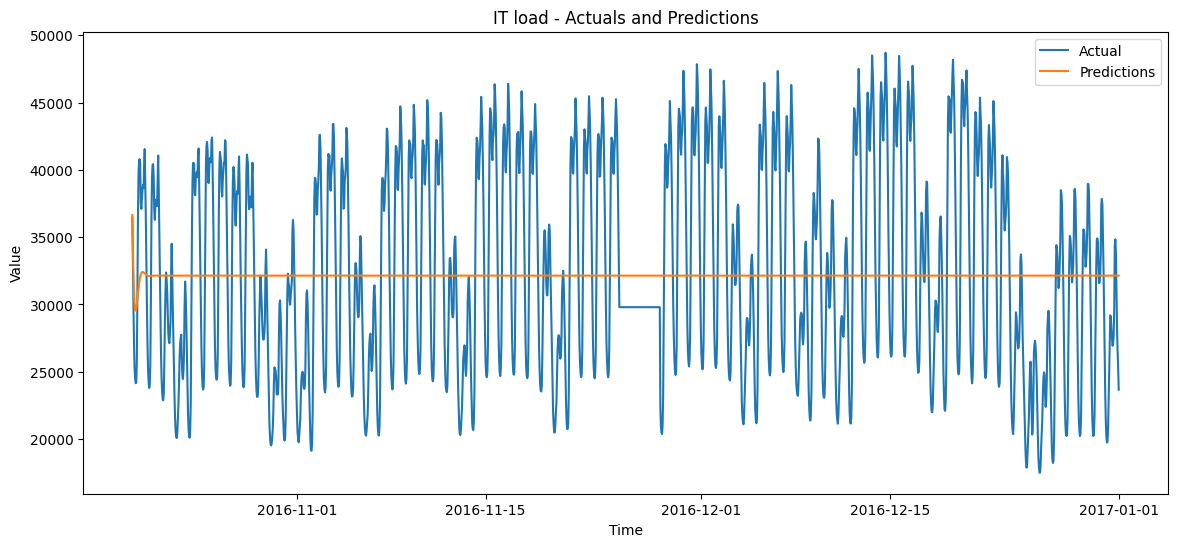

In [64]:
# plotting actual and predicted values

plt.figure(figsize=(14,6))
plt.plot(data['utc_timestamp'][train_size:], test , label = 'Actual')
plt.plot(data['utc_timestamp'][train_size:], predictions_1 , label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('IT load - Actuals and Predictions')
plt.legend()
plt.show()

#### Build ARIMA model for 'IT Solar Generation'

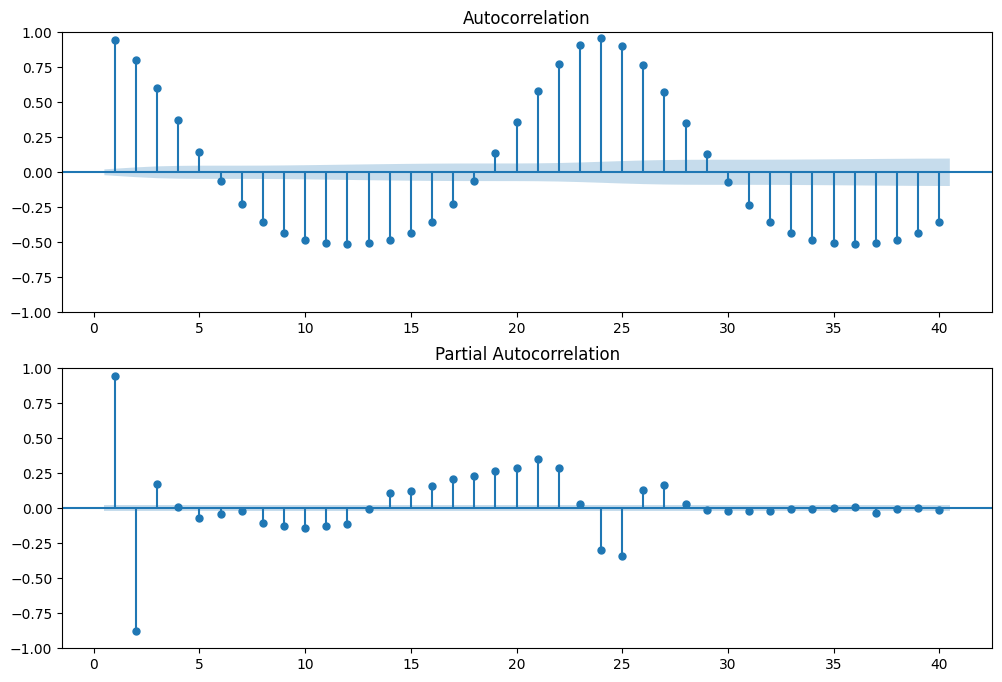

In [65]:
# plotting ACF and PACF

fig, (ax1,ax2) = plt.subplots(2,1,figsize = (12,8))
sgt.plot_acf(data['IT_solar_generation'], lags =40, zero = False, ax = ax1)
sgt.plot_pacf(data['IT_solar_generation'], lags =40, zero = False, ax = ax2)
plt.show()

From the ACF plot, we see a gradual decrease, and from the PACF plot, there is a sharp drop after lag 2. So we can take p=2 and q=2 as our model parameters.

In [66]:
# splitting data into training and sets

train_size = int(len(data['IT_solar_generation']) * 0.8)
train, test = data['IT_solar_generation'][:train_size],data['IT_solar_generation'][train_size:]

# fit the arima model (2,0,2)

model =  ARIMA(train, order= (2,0,2))
model_fit = model.fit()

# make predictions on the test set

predictions_1 = model_fit.predict(start = len(train), end = len(train) + len(test) -1)

# Calculate RMSE

rmse = sqrt (mean_squared_error(test,predictions_1))
rmse

2486.150711088173

In [67]:
# fit the arima model (2,1,2)

model =  ARIMA(train, order= (2,1,2))
model_fit = model.fit()

# make predictions on the test set

predictions_2 = model_fit.predict(start = len(train), end = len(train) + len(test) -1)

# Calculate RMSE

rmse = sqrt (mean_squared_error(test,predictions_2))
rmse

2364.522280101766

In [68]:
# fit the arima model (2,2,2)

model =  ARIMA(train, order= (2,2,2))
model_fit = model.fit()

# make predictions on the test set

predictions_3 = model_fit.predict(start = len(train), end = len(train) + len(test) -1)

# Calculate RMSE

rmse = sqrt (mean_squared_error(test,predictions_3))
rmse

2335.3325236051182

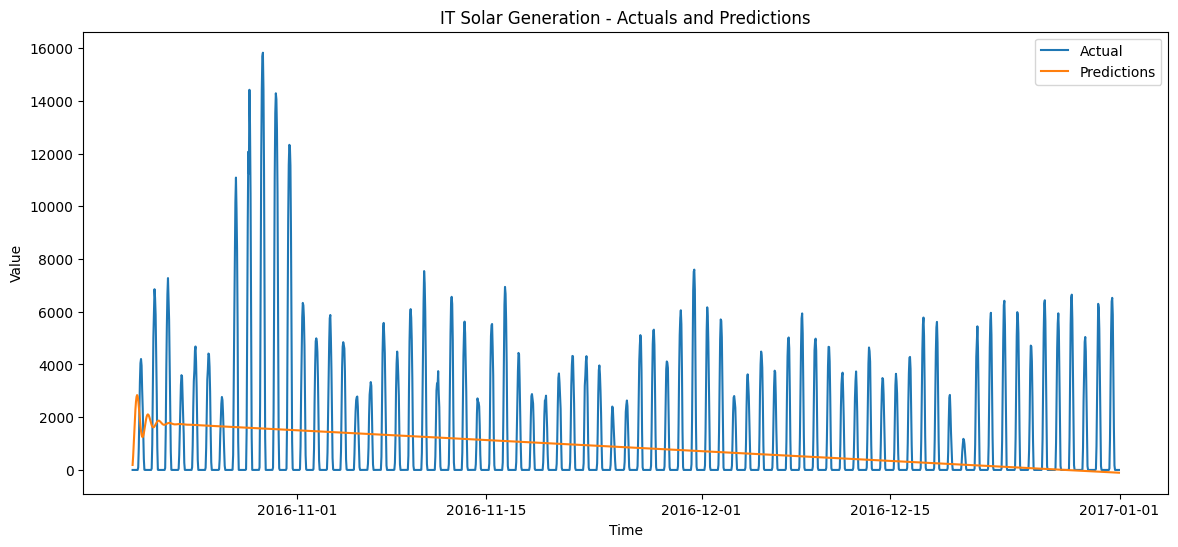

In [69]:
# plotting actual and predicted values

plt.figure(figsize=(14,6))
plt.plot(data['utc_timestamp'][train_size:], test , label = 'Actual')
plt.plot(data['utc_timestamp'][train_size:], predictions_3 , label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('IT Solar Generation - Actuals and Predictions')
plt.legend()
plt.show()